In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [95]:
torch.cuda.is_available()


False

In [2]:
import requests 
url="https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
res=requests.get(url)
words=(res.text).splitlines()
print(len(words),max(len(w) for w in words),min(len(w) for w in words))

32033 15 2


In [25]:
chars =sorted(list(set((''.join(words))))) #get unique characters 
stoi={s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."]=0 
itos={i:s for s,i in stoi.items()}         # map int to char
vocab_size=len(itos)

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


tensor(0.0111) tensor(1.0033)
tensor(0.0016) tensor(1.0076)


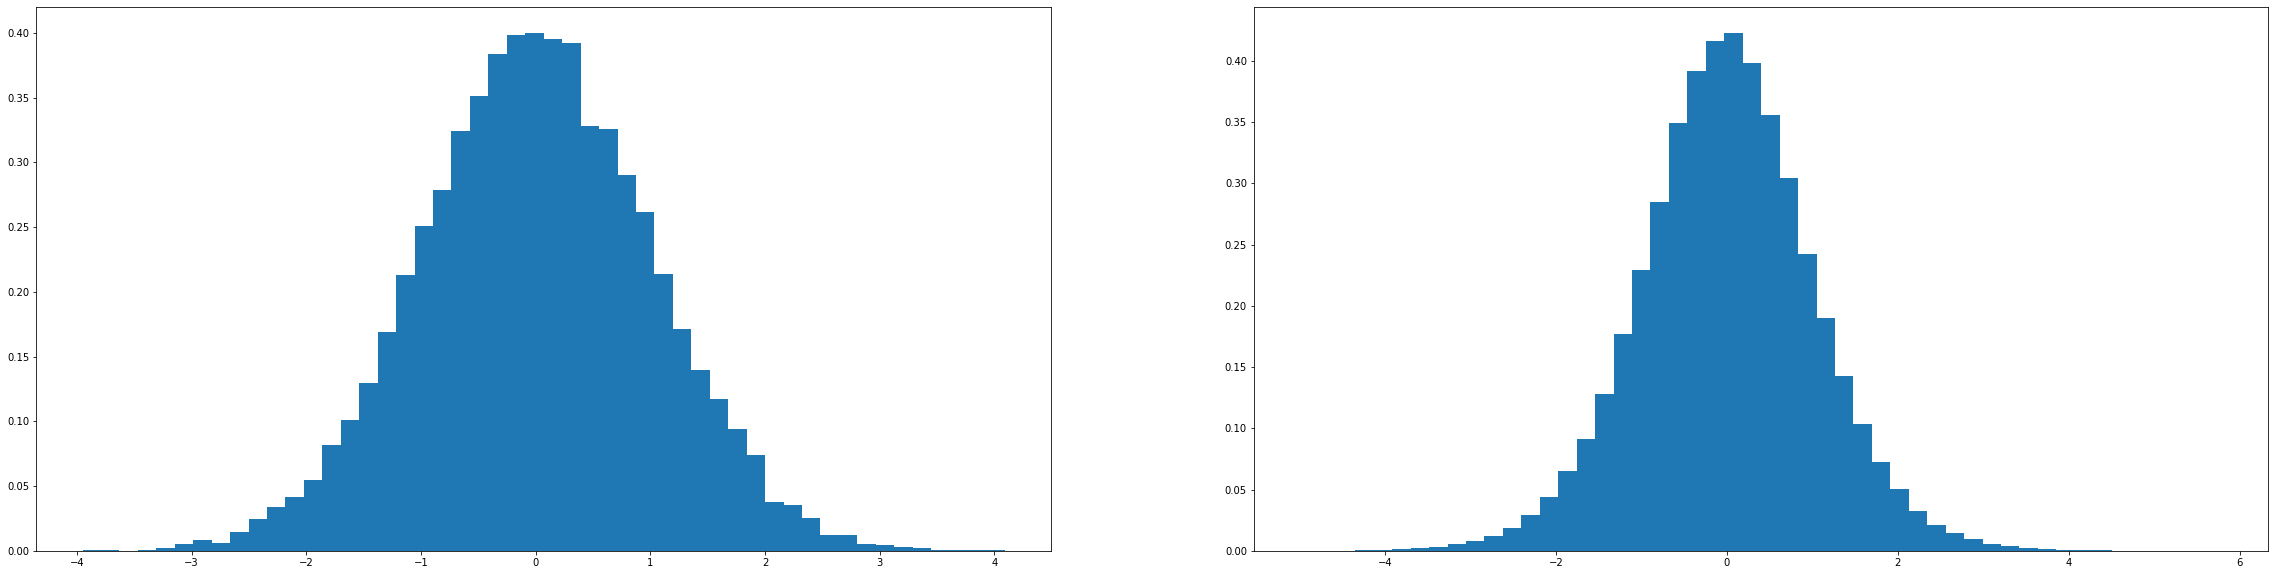

In [11]:
#Kaiming Init https://arxiv.org/pdf/1502.01852.pdf
x = torch.randn(1000, 10)
w = torch.randn(10, 200) /10**0.5 # square root of the fan in to preserve the standnard deviaition
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(40,10))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
pass

tensor(-0.0003) tensor(0.9996)
tensor(0.5633) tensor(0.8263)


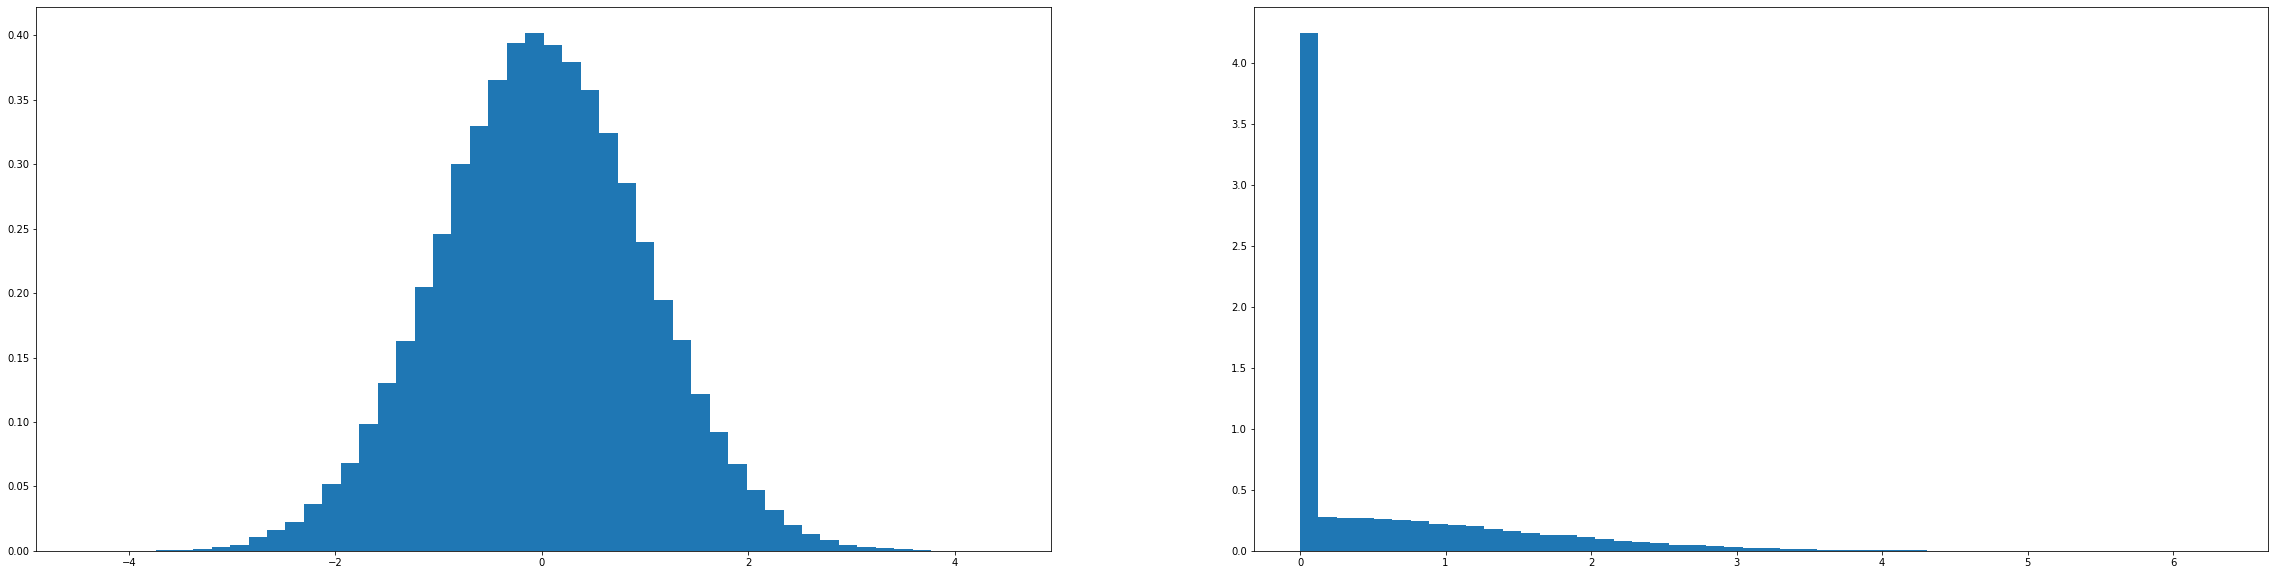

In [23]:
x=torch.randn(1000,100)
y=torch.relu(x)*(2**0.5)
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(40,10))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
pass

tensor(-0.0006) tensor(0.9960)
tensor(-0.0013) tensor(1.0459)


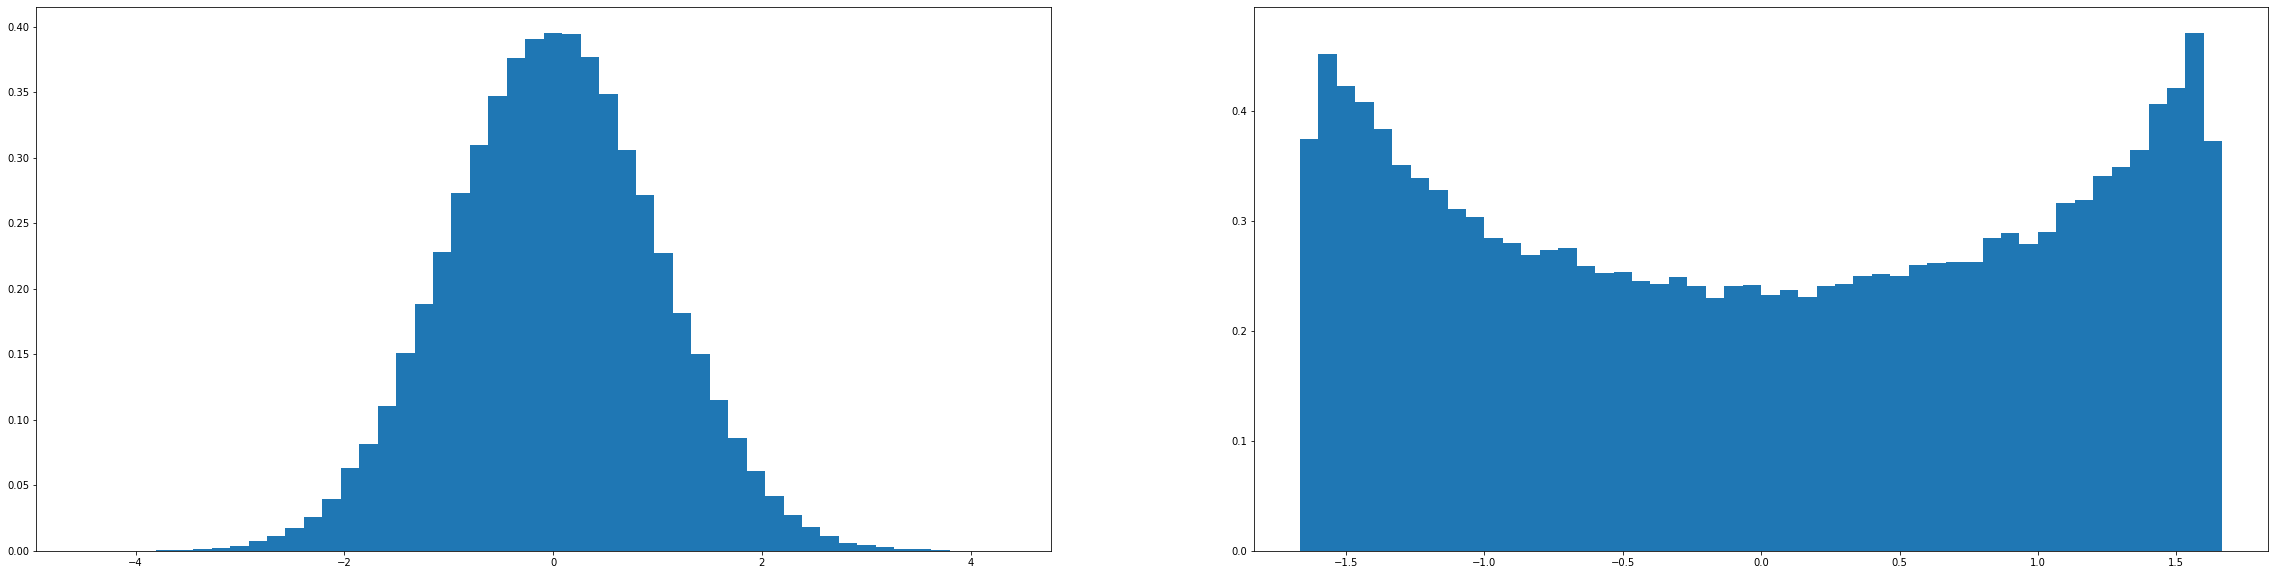

In [21]:
x=torch.randn(1000,100)
y=torch.tanh(x)*(5/3)
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(40,10))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
pass

In [72]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C =  torch.randn((27, n_embd),                  generator=g)

W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)*((5/3)/((n_embd*block_size)**0.5)) #kaiming init
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnstd_running = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))


parameters = [C, W1, b1, W2, b2,bngain,bnbias]
for p in parameters:
  p.requires_grad = True

lri = []
lossi = []
stepi = []

In [78]:
hpreact.shape,bnmean.shape

(torch.Size([32, 200]), torch.Size([1, 200]))

(array([  17.,  139.,  681., 1823., 2847., 2601., 1401.,  422.,   65.,
           4.]),
 array([-3.65718699, -2.89989369, -2.14260039, -1.3853071 , -0.6280138 ,
         0.12927949,  0.88657279,  1.64386609,  2.40115938,  3.15845268,
         3.91574597]),
 <BarContainer object of 10 artists>)

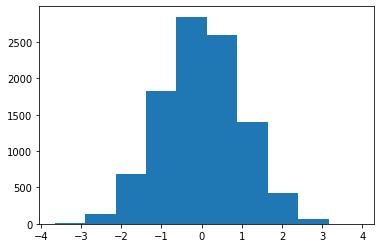

In [94]:
a=torch.randn((100,100))
amean = a.mean(0,keepdim=True)
astd = a.std(0,keepdim=True)

b=(a-amean)/astd
b
# torch.tanh(a)
plt.hist(b.view(-1).tolist())

In [73]:
max_steps=20000
n_samples=32

lossi=[]
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (n_samples,))
  
  # forward pass
  emb = C[Xtr[ix]]           #embed charchters in to vectors
  embcat = emb.view(-1, 30)    #convert 3*10 to n_sammples*30
  
  hpreact = embcat @ W1 #+ b1
  bnmeani = hpreact.mean(dim=0, keepdim=True) 
  bnstdi = hpreact.std(dim=0, keepdim=True)
  hpreact =( hpreact - bnmeani)/ bnstdi #subtract the mean & divide by the standard deviation 
  hpreact = hpreact * bngain +bnbias

  with torch.no_grad():
    bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
    bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

  h = torch.tanh(hpreact) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())
  if i%200==0:

    print(loss)
  lossi.append(loss.item())


tensor(3.3215, grad_fn=<NllLossBackward0>)
tensor(2.6544, grad_fn=<NllLossBackward0>)
tensor(2.4743, grad_fn=<NllLossBackward0>)
tensor(2.7055, grad_fn=<NllLossBackward0>)
tensor(2.6746, grad_fn=<NllLossBackward0>)
tensor(2.8371, grad_fn=<NllLossBackward0>)
tensor(2.7618, grad_fn=<NllLossBackward0>)
tensor(2.3913, grad_fn=<NllLossBackward0>)
tensor(2.2453, grad_fn=<NllLossBackward0>)
tensor(2.7426, grad_fn=<NllLossBackward0>)


KeyboardInterrupt: 

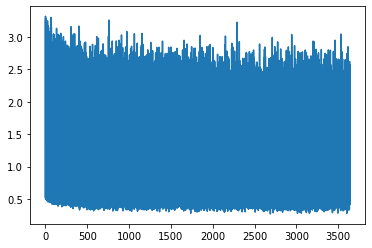

In [74]:
plt.plot(lossi)

In [77]:
bnstd.shape

torch.Size([1, 200])

tensor(-0.0255, grad_fn=<MeanBackward0>) tensor(1.0254, grad_fn=<StdBackward0>)


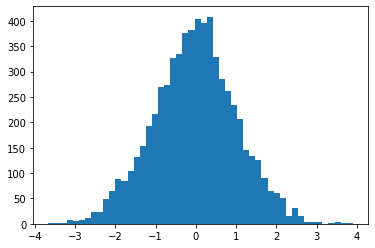

In [64]:
print(hpreact.mean(),hpreact.std())
plt.hist(hpreact.view(-1).tolist(),50)
pass

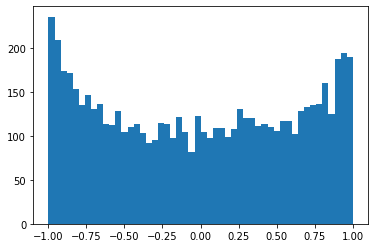

In [65]:
plt.hist(h.view(-1).tolist(),50)
pass

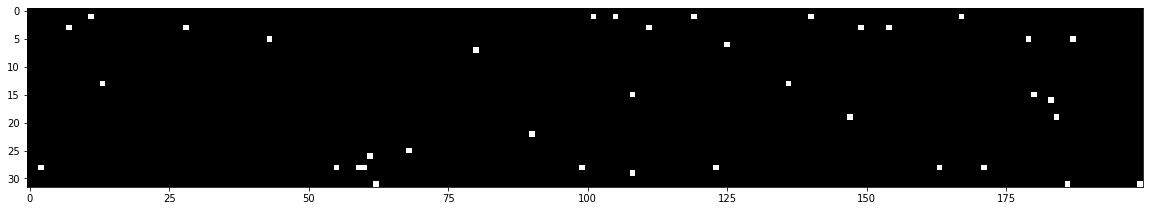

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap="gray",interpolation='nearest')

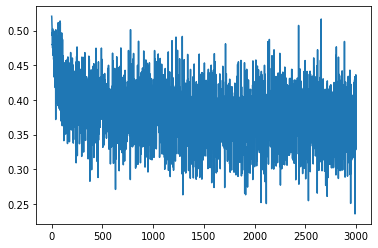

In [ ]:
plt.plot(lossi)

In [ ]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
embcat = emb.view(-1, 30)
hpreact = embcat @ W1 + b1
hpreact = hpreact-hpreact.mean(dim=0, keepdim=True) #subtract the mean
hpreact = hpreact/hpreact.std(dim=0, keepdim=True)  #divide by the standard deviation 
hpreact = hpreact * bngain +bnbias
h = torch.tanh(hpreact) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(f"train loss {loss}")
# validation loss
emb = C[Xdev] # (32, 3, 2)
embcat = emb.view(-1, 30)
hpreact = embcat @ W1 + b1
hpreact = hpreact-hpreact.mean(dim=0, keepdim=True) #subtract the mean
hpreact = hpreact/hpreact.std(dim=0, keepdim=True)  #divide by the standard deviation 
hpreact = hpreact * bngain +bnbias
h = torch.tanh(hpreact) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(f"val loss {loss}")
# test loss
emb = C[Xte] # (32, 3, 2)
embcat = emb.view(-1, 30)
hpreact = embcat @ W1 + b1
hpreact = hpreact-hpreact.mean(dim=0, keepdim=True) #subtract the mean
hpreact = hpreact/hpreact.std(dim=0, keepdim=True)  #divide by the standard deviation 
hpreact = hpreact * bngain +bnbias
h = torch.tanh(hpreact) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(f"test  loss {loss}")

train loss 2.6418099403381348
val loss 2.640054941177368
test  loss 2.6427321434020996


In [ ]:
# Everything here is after 1000 steps

# Raw model
    # train loss 7.168619632720947
    # val loss 7.161382675170898
    # test  loss 7.177533149719238
# Weights with proper initialization
    # train loss 2.3786191940307617
    # val loss 2.373582363128662
    # test  loss 2.374671220779419

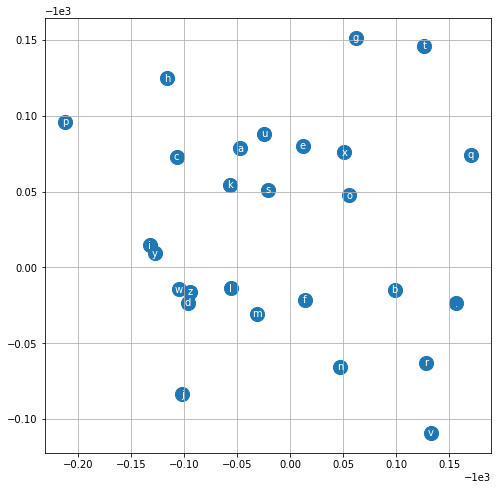

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cbrpzhxqtbfhqvufkwmrpxgthtykhkcasskejrzhnbnfqpwsyhc.
vgqeiunrzmuqptcmziivduslhggphhbmgpoinfqsqjtzsrlixwawvvdbquwqjthogdjaryxixfkqeupiusdbwed.
ecxiatgtlffhysfkquhpqgmovdjhksyjrpmqqosozswjcojqmwycjsfrenqkpfsadluuo.
zoessrkoiazhrynhr.
opklhynrxyh.
xqioloqbprbvbbda.
ipyqmuitjpbvfpzpddgpycsislqwkkmcrkzauqnyjydpk.
kvweskauikzamdtefl.
ky.
qdyctoorowooktbykouokfbfcw.
zoipkzcs.
su.
eoaiunqqerosci.
ipjzyfbadyigluglcufwzyzdjokhnlhsjqsxmuadltjhvtoyaplwuw.
xisxwrdfv.
zphtzbiuzzsrvgpknbfyntiysfgdgkgmmj.
pugcrvdhpvdafpsdvkhzkxkimtvoscjupgawjmjqjwgvjflwkewtxjrclxdytpvhgqllyuil.
hiuc.
sfcmkjpmubjbiygh.
sqkaxzkkiihkncfslyfgevbayl.
